# Monte Carlo and TD Algorithm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/')

In [ ]:
!git clone https://github.com/mpatacchiola/dissecting-reinforcement-learning.git

Cloning into 'dissecting-reinforcement-learning'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 491 (delta 11), reused 9 (delta 2), pack-reused 464 (from 1)
Receiving objects: 100% (491/491), 28.83 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (254/254), done.
Updating files: 100% (81/81), done.


In [ ]:
!python /content/drive/MyDrive/dissecting-reinforcement-learning/src/2/montecarlo_control.py


State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]
Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]

State-Action matrix after 1 iterations:
[[ 5.73063771e+09  5.89035440e+09  4.28064759e+09  3.75857976e+09
   2.66925253e+09  8.48003212e+09  5.57633951e+09  5.24345632e+09
   6.81879706e+09  7.97489588e+08  6.47409805e+09  6.61522849e+09]
 [ 2.67263226e+09  1.26257212e+09  7.97655416e+09  6.34589763e+09
   2.10506912e+09  3.76695570e+09  3.35255274e+09  1.36934899e+09
   3.84360091e+08 -1.14205672e+01  3.83809723e+09  8.70636023e+09]
 [ 8.36887510e+09  6.23098959e+09  5.59517703e+09  8.43944016e+09
   3.48443083e+09  9.22596773e+09 -1.12462609e+01  1.39428690e+08
   6.45649247e+08  5.89098531e+09  4.33602095e+09 -1.22692960e+01]
 [ 7.84738045e+09  9.59527533e+09  3.91133462e+09  1.92461667e+08
   7.49858652e+09  1.51035625e+09  2.55430815e+09  9.95932670e+09
   7.09782497e+09  6.75243630e+09 -1.12876514e+01 -1.13405275

State-Action matrix after 1 iterations:
[[ 1.97132882e+09  2.30380520e+09  5.32416253e+09  8.22740378e+08
   4.91481884e+08  3.24092528e+09  9.59419033e+08  9.86933809e+09
   8.42486442e+09 -2.44195537e+01  6.41816436e+09  8.42813772e+09]
 [ 8.28559999e+09  5.85608730e+09  2.96074226e+09  9.73485568e+09
   4.33227845e+09  6.85326335e+09  7.75483742e+09  1.99593702e+09
  -2.51476051e+01  4.82675576e+09  9.03008889e+09  8.53883712e+09]
 [ 3.12116962e+09  2.62581359e+09  5.49232707e+09  1.69565520e+09
  -2.41707142e+01  9.72525939e+09  8.66496699e+09  6.20976051e+09
   7.70075902e+09  2.43389752e+09  5.52888223e+09  4.68103554e+09]
 [ 5.23929463e+09  9.08756759e+09  1.92789593e+09  6.51982840e+09
   2.90263671e+09  2.06191180e+09  5.81216412e+09  9.60293030e+09
  -2.42607306e+01  7.11434182e+09 -2.50254946e+01  5.60399790e+09]]
State-Action matrix after 3001 iterations:
[[-1.71268267e-01  1.55600255e-01  7.88100971e-01  8.22740378e+08
  -4.26648105e-01  3.24092528e+09  7.10628634e-01  9.8

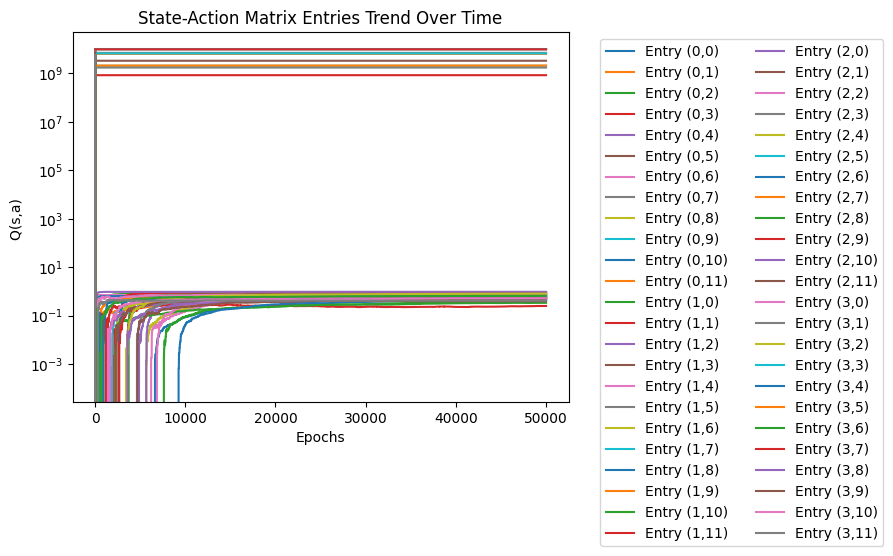

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dissecting-reinforcement-learning/src/2/')

import matplotlib.pyplot as plt
import numpy as np
from gridworld import GridWorld
from montecarlo_control import *

def main():

    env = GridWorld(3, 4)

    # Define the state matrix
    state_matrix = np.zeros((3,4))
    state_matrix[0, 3] = 1
    state_matrix[1, 3] = 1
    state_matrix[1, 1] = -1

    # Define the reward matrix
    reward_matrix = np.full((3,4), -0.04)
    reward_matrix[0, 3] = 1
    reward_matrix[1, 3] = -1

    # Define the transition matrix
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])

    # Random policy
    policy_matrix = np.random.randint(low=0, high=4, size=(3, 4)).astype(np.float32)
    policy_matrix[1,1] = np.NaN  # NaN for the obstacle at (1,1)
    policy_matrix[0,3] = policy_matrix[1,3] = -1  # No action for the terminal states

    env.setStateMatrix(state_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)

    state_action_matrix = np.random.random_sample((4,12))  # Q
    running_mean_matrix = np.full((4,12), 1.0e-10)  # Initialize to avoid division by zero
    gamma = 0.999
    tot_epoch = 50000
    print_epoch = 3000

    # Create a list to track the state-action values over epochs
    state_action_history = []

    for epoch in range(tot_epoch):
        episode_list = list()
        observation = env.reset(exploring_starts=True)
        is_starting = True

        for _ in range(1000):
            action = policy_matrix[observation[0], observation[1]]
            if is_starting:
                action = np.random.randint(0, 4)
                is_starting = False
            new_observation, reward, done = env.step(action)
            episode_list.append((observation, action, reward))
            observation = new_observation
            if done: break

        # First-visit MC: Estimate return and update state-action values
        counter = 0
        checkup_matrix = np.zeros((4,12))
        for visit in episode_list:
            observation, action, reward = visit
            col = int(observation[1] + (observation[0]*4))
            row = int(action)
            if checkup_matrix[row, col] == 0:
                return_value = get_return(episode_list[counter:], gamma)
                running_mean_matrix[row, col] += 1
                state_action_matrix[row, col] += return_value
                checkup_matrix[row, col] = 1
            counter += 1

        policy_matrix = update_policy(episode_list, policy_matrix, state_action_matrix / running_mean_matrix)

        # Append the normalized state-action matrix to history at each epoch
        state_action_history.append(np.copy(state_action_matrix / running_mean_matrix))

        if epoch % print_epoch == 0:
            print(f"State-Action matrix after {epoch+1} iterations:")
            print(state_action_matrix / running_mean_matrix)

    # Convert history to a NumPy array for easy slicing
    state_action_history = np.array(state_action_history)

    # Plot the trends of each entry
    epochs = np.arange(tot_epoch)

    for row in range(4):
        for col in range(12):
            plt.plot(epochs, (state_action_history[:, row, col]), label=f"Entry ({row},{col})")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Q(s,a) ")
    plt.title("State-Action Matrix Entries Trend Over Time")
    #plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.6f'))  # Increase precision to 6 decimal places
    #plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10])  # Example of powers of 10
    #plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Display values in scalar format

    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), ncol=2)  # Adjust legend outside plot
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
!python /content/drive/MyDrive/dissecting-reinforcement-learning/src/3/temporal_differencing_control_qlearning.py

State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]
Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]
Policy Matrix:
[[ 0.  0.  1. -1.]
 [ 1. nan  0. -1.]
 [ 1.  1.  2.  2.]]
 ^   ^   >   *  
 >   #   ^   *  
 >   >   v   v  

Exploratory Policy Matrix:
[[ 1.  1.  1. -1.]
 [ 0. nan  0. -1.]
 [ 0.  1.  0.  3.]]
 >   >   >   *  
 ^   #   ^   *  
 ^   >   ^   <  


Epsilon: 0.1
State-Action matrix after 1 iterations:
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.001  0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]]
Policy matrix after 1 iterations:
 ^   ^   >   *  
 >   #   ^   *  
 >   >   v   v  


Epsilon: 0.0954992586021436
State-Action matrix after 1001 iterations:
[[-1.2272623


Epsilon: 0.1
State-Action matrix after 1 iterations:
[[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -7.996e-05  0.000e+00
   0.000e+00  0.000e+00 -4.000e-05  0.000e+00  0.000e+00  0.000e+00]
 [-7.996e-05 -4.000e-05  1.000e-03  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00 -4.000e-05  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]
Policy matrix after 1 iterations:
 ^   ^   >   *  
 >   #   <   *  
 v   v   v   >  


Epsilon: 0.0954992586021436
State-Action matrix after 1001 iterations:
[[-9.63629290e-04  1.95379019e-04  7.15711050e-03  0.00000000e+00
  -1.15371632e-02  0.00000000e+00  6.21373646e-02  0.00000000e+00
  -5.59987299e-03 -1.11669203e-03 -8.72411422e-03 -2.29303942e-02]
 [-2.55985707e-03  1.06082303e-01  5.518

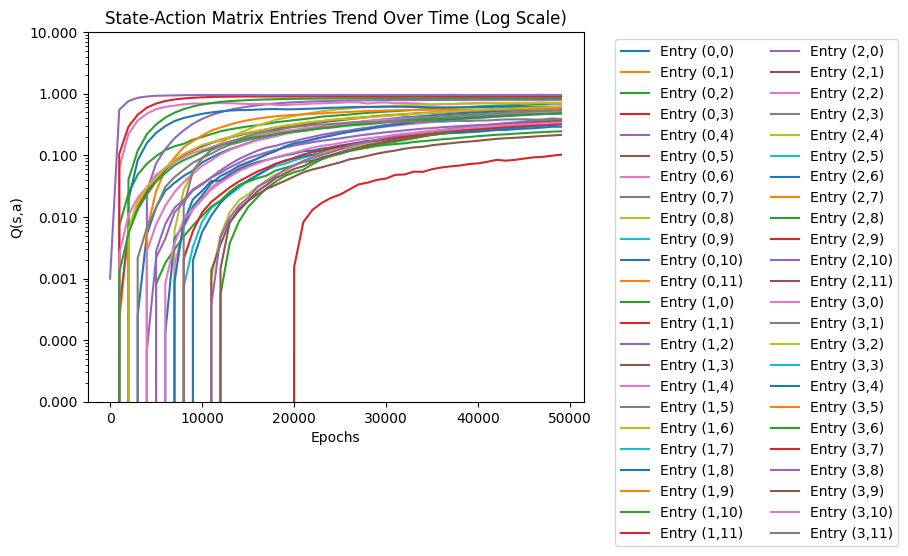

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dissecting-reinforcement-learning/src/3/')

import matplotlib.pyplot as plt
from temporal_differencing_control_qlearning import *
def main():
    env = GridWorld(3, 4)

    # Define matrices (state, reward, transition, policy, etc.)
    state_matrix = np.zeros((3,4))
    state_matrix[0, 3] = 1
    state_matrix[1, 3] = 1
    state_matrix[1, 1] = -1
    reward_matrix = np.full((3,4), -0.04)
    reward_matrix[0, 3] = 1
    reward_matrix[1, 3] = -1
    transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]])

    # Random policy
    policy_matrix = np.random.randint(low=0, high=4, size=(3, 4)).astype(np.float32)
    policy_matrix[1, 1] = np.NaN
    policy_matrix[0, 3] = policy_matrix[1, 3] = -1

    exploratory_policy_matrix = np.array([[1,      1, 1, -1],
                                          [0, np.NaN, 0, -1],
                                          [0,      1, 0,  3]])

    env.setStateMatrix(state_matrix)
    env.setRewardMatrix(reward_matrix)
    env.setTransitionMatrix(transition_matrix)

    state_action_matrix = np.zeros((4,12))
    visit_counter_matrix = np.zeros((4,12))
    gamma = 0.999
    alpha = 0.001
    tot_epoch = 50000
    print_epoch = 1000

    # To store the history of state-action matrix for plotting
    state_action_history = np.zeros((tot_epoch//print_epoch, 4, 12))

    for epoch in range(tot_epoch):
        observation = env.reset(exploring_starts=True)
        epsilon = return_decayed_value(0.1, epoch, decay_step=50000)
        is_starting = True
        for step in range(1000):
            action = return_epsilon_greedy_action(exploratory_policy_matrix, observation, epsilon=0.001)
            if is_starting:
                action = np.random.randint(0, 4)
                is_starting = False
            new_observation, reward, done = env.step(action)
            state_action_matrix = update_state_action(state_action_matrix, visit_counter_matrix, observation, new_observation,
                                                      action, reward, alpha, gamma)
            policy_matrix = update_policy(policy_matrix, state_action_matrix, observation)
            visit_counter_matrix = update_visit_counter(visit_counter_matrix, observation, action)
            observation = new_observation
            if done: break

        # Store state-action matrix periodically for plotting
        if epoch % print_epoch == 0:
            state_action_history[epoch//print_epoch] = state_action_matrix
            print("")
            print("Epsilon: " + str(epsilon))
            print("State-Action matrix after " + str(epoch+1) + " iterations:")
            print(state_action_matrix)
            print("Policy matrix after " + str(epoch+1) + " iterations:")
            print_policy(policy_matrix)


    # Time to plot the state-action matrix entries over time
    epochs = np.arange(0, tot_epoch, print_epoch)
    for row in range(4):
        for col in range(12):
            plt.plot(epochs, state_action_history[:, row, col], label=f"Entry ({row},{col})")

    plt.yscale('log')  # Apply logarithmic scale to the y-axis
    plt.xlabel("Epochs")
    plt.ylabel("Q(s,a)")
    plt.title("State-Action Matrix Entries Trend Over Time (Log Scale)")

    # Set y-ticks for better visualization (adjust based on value range)
    plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
    plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter())

    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), ncol=2)
    plt.show()


if __name__ == "__main__":
    main()
